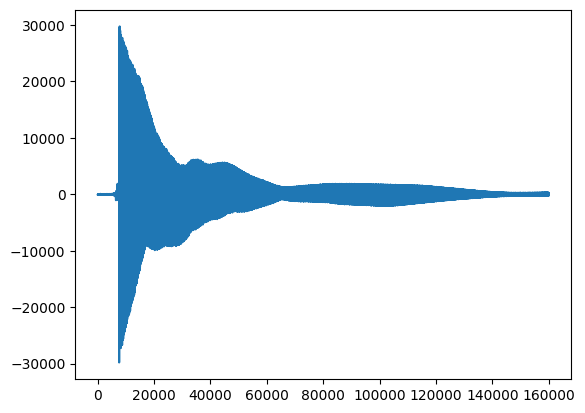

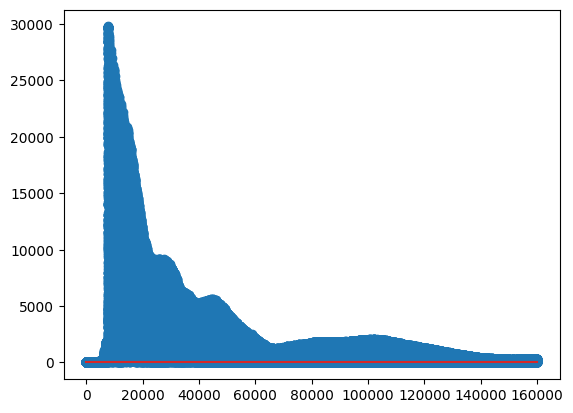

In [82]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read

samplerate, data = read("sounds/note_guitare_LAd.wav")
plt.plot(data)
plt.show()

plt.stem(np.abs(data))
plt.show()

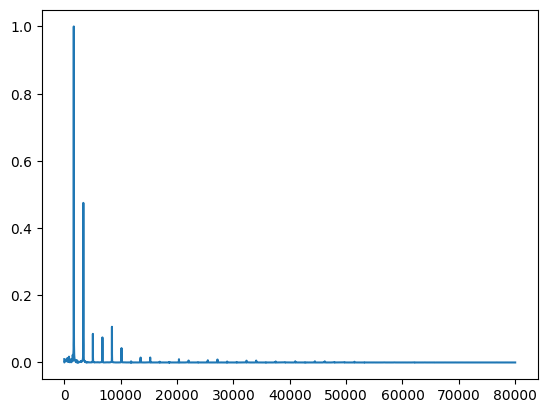

1690
465.80625000000003


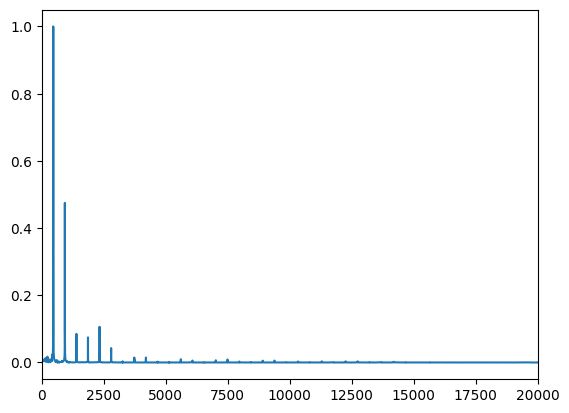

In [83]:
fft_spect = np.fft.rfft(data)
arr_freq = np.fft.rfftfreq(data.size, d=1./samplerate)
amp_fft_spect = np.abs(fft_spect)
phase_fft_spect = np.angle(fft_spect)

amp_fft_spect /= np.max(amp_fft_spect)


plt.plot(amp_fft_spect)
plt.show()

print(np.argmax(amp_fft_spect))
print(arr_freq[np.argmax(amp_fft_spect)])

plt.plot(arr_freq, amp_fft_spect)
plt.xlim(0, 20000)
plt.show()

In [84]:
# Aller chercher les 32 plus grosses amp et leur freq
N = 32
inx = np.argpartition(amp_fft_spect, -N)[-N:]
for i in inx:
    print(f"freq : {arr_freq[i]}, amp : {amp_fft_spect[i]}")

freq : 468.838125, amp : 0.1731351315611143
freq : 933.541875, amp : 0.17483684420988835
freq : 468.5625, amp : 0.19384819090515074
freq : 932.990625, amp : 0.28864687595967964
freq : 462.774375, amp : 0.20304738169781278
freq : 463.05, amp : 0.25276485357881845
freq : 463.325625, amp : 0.2651697684944054
freq : 463.60125, amp : 0.27181861632280996
freq : 463.87687500000004, amp : 0.2943642077166398
freq : 464.15250000000003, amp : 0.3195975542538599
freq : 464.428125, amp : 0.36937405301636683
freq : 464.70375, amp : 0.4282436280961847
freq : 464.979375, amp : 0.6273877055117606
freq : 465.255, amp : 0.9662318930180578
freq : 465.53062500000004, amp : 0.9696657823198782
freq : 465.80625000000003, amp : 1.0
freq : 466.081875, amp : 0.4506932490089334
freq : 466.3575, amp : 0.2820805741937051
freq : 466.633125, amp : 0.4039702092092968
freq : 466.90875, amp : 0.4058651616889154
freq : 467.184375, amp : 0.3651734655215832
freq : 467.46000000000004, amp : 0.3159628346373033
freq : 467.735

[  465.80625   931.6125   1397.41875  1863.225    2329.03125  2794.8375
  3260.64375  3726.45     4192.25625  4658.0625   5123.86875  5589.675
  6055.48125  6521.2875   6987.09375  7452.9      7918.70625  8384.5125
  8850.31875  9316.125    9781.93125 10247.7375  10713.54375 11179.35
 11645.15625 12110.9625  12576.76875 13042.575   13508.38125 13974.1875
 14439.99375 14905.8    ]


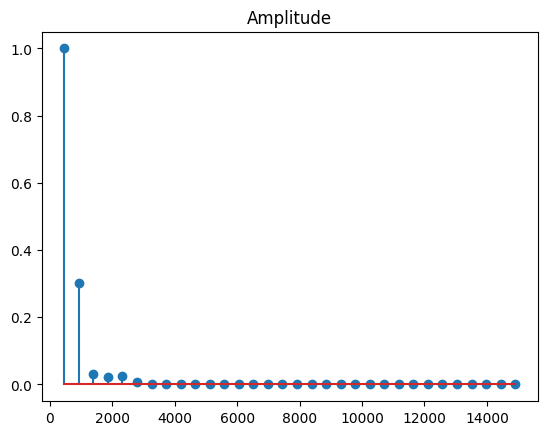

In [85]:
# Frequences fondamentales
freq_fondamentale = arr_freq[np.argmax(amp_fft_spect)] 
freq_harmoniques = np.arange(freq_fondamentale, (N + 1)*freq_fondamentale, freq_fondamentale)
print(freq_harmoniques) 

# Find nearest freq_harmoniques in freq
#  where is freq_f in freq ?
def find_nearest_idx(arr, val):
    arr = np.asarray(arr)
    return (np.abs(arr - val)).argmin()

real_freq_harmoniques = []
arr_amp_n = []
arr_phase_n = []

for f_h in freq_harmoniques:
    idx = find_nearest_idx(arr_freq, f_h)
    real_freq_harmoniques.append(arr_freq[idx])
    arr_amp_n.append(amp_fft_spect[idx])
    arr_phase_n.append(phase_fft_spect[idx])
    

plt.stem(real_freq_harmoniques,  arr_amp_n)
plt.title('Amplitude')
plt.show()



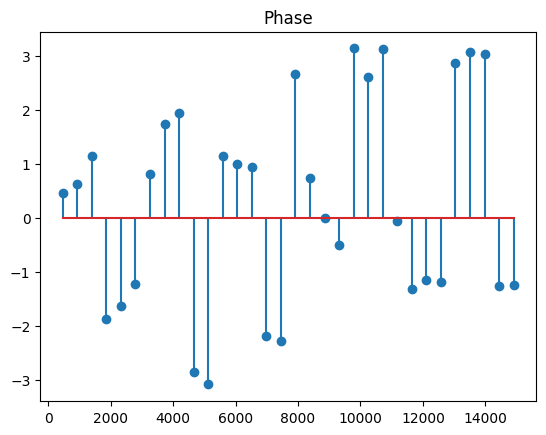

In [86]:
plt.stem(real_freq_harmoniques, arr_phase_n)
plt.title('Phase')
plt.show()